In [1]:
import cv2
import sklearn
import numpy as np
import os
import fnmatch
import csv
import tqdm
import matplotlib.pyplot as plt

выгружаем картинки из соотвествующих хранилищ

In [2]:
RusTargetPath = 'D:\\ComputerVision\\_robocar\\laneDetection\\_scraps\\06_SVM_RoadSignDetector\\ImgTrainRus\\'
GermTargetPath = 'D:\\ComputerVision\\_robocar\\laneDetection\\_scraps\\06_SVM_RoadSignDetector\\ImgTrainGerm\\'

#targetFolders = ['0','1','2','3','4','5','6']
targetFolders = ['1','2','3','4','5','6']

In [3]:
X = []
labels = []

for folder in targetFolders:
    for imgName in os.listdir(RusTargetPath + folder + '\\'):
        image = cv2.imread(RusTargetPath + folder + '\\' + imgName)
        X.append(image)
        labels.append(int(folder))
        
    for imgName in os.listdir(GermTargetPath + folder + '\\'):
        image = cv2.imread(GermTargetPath + folder + '\\' + imgName)
        X.append(image)
        labels.append(int(folder))    

46151


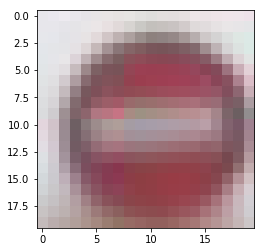

In [4]:
print(len(X))

plt.imshow(cv2.cvtColor(X[0],cv2.COLOR_BGR2RGB))
plt.show()

Построим гисторамму новых классов

In [5]:
print(len(X))

46151


0-всё остальное; 1 - кирпич; 2 - налево; 3- направо; 4-прямо; 5-прямо и направо; 6- прямо и налево
все классы


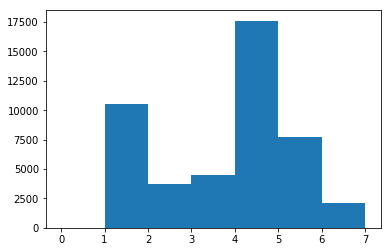

только спец классы


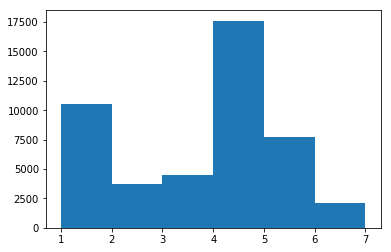

In [6]:
print('0-всё остальное; 1 - кирпич; 2 - налево; 3- направо; 4-прямо; 5-прямо и направо; 6- прямо и налево')

print('все классы')
plt.hist(labels,7,[0,7]);  
plt.show()

print('только спец классы')
plt.hist(labels,6,[1,7]);  
plt.show()

Тут можно посмотреть случайные картинки с их классами и распределение по классам

А так же хорошо было бы объединить классы где надо и пересчитать статистику

In [7]:
from mpl_toolkits.axes_grid1 import ImageGrid
import imutils
from matplotlib.colors import Colormap

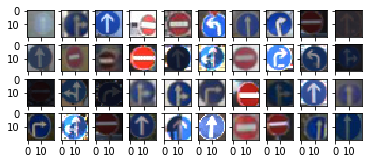

In [8]:
rand_len= 40
X_rand_idx = np.random.choice(len(X), rand_len)


plt.set_cmap(Colormap("Greys"))
fig = plt.figure(1, (10., 10.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(4, 10), 
                 axes_pad=0.1,
                 )

for i in range(rand_len):
    grid[i].imshow(cv2.cvtColor(X[X_rand_idx[i]],cv2.COLOR_BGR2RGB)) 

plt.show()

Аугментация:

    сдвиг
    
    поворот
    
    отражение

In [9]:
#отражение типов
#2 -> 3
#3 -> 2
#4 -> 5
#5 -> 4

def labelReverser(oldLabel):
    newLabel = {
        2: 3,
        3: 2,
        5: 6,
        6: 5
    }
    return newLabel.get(oldLabel, 0)

X_add = []
lab_add = []

for i,label in enumerate(labels):
    newLabel = labelReverser(label)
    if (newLabel != 0):
        X_add.append(cv2.flip( X[i], 1 ))
        lab_add.append(newLabel)
        
X = X + X_add
labels = labels + lab_add

только спец классы. после вертикального отражения


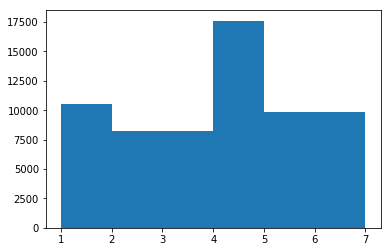

In [10]:
print('только спец классы. после вертикального отражения')
plt.hist(labels,6,[1,7]);  
plt.show()

Вот тут мы "догружаем" обычных картинок

In [11]:
ZeroFolderLen = 10000
exFolder = '0'

X_zero = []
labels_zero = []
    
for imgName in os.listdir(RusTargetPath + exFolder + '\\')[:ZeroFolderLen]:
    image = cv2.imread(RusTargetPath + exFolder + '\\' + imgName)
    X_zero.append(image)
    labels_zero.append(int(exFolder))

for imgName in os.listdir(GermTargetPath + exFolder + '\\')[:ZeroFolderLen]:
    image = cv2.imread(GermTargetPath + exFolder + '\\' + imgName)
    X_zero.append(image)
    labels_zero.append(int(exFolder))

создадим 2 сабдатасета:

первый с 10к 0ых
второй с 20к 0ых

In [12]:
print(len(X_zero))

20000


In [13]:
X_20k = X + X_zero
labels_20k = labels + labels_zero

X_10k = X + X_zero[:10000]
labels_10k = labels + labels_zero[:10000]

все классы после добавления нулевых в 20к датасете


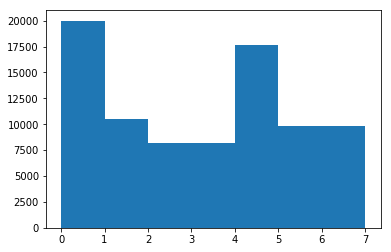

все классы после добавления нулевых в 10к датасете


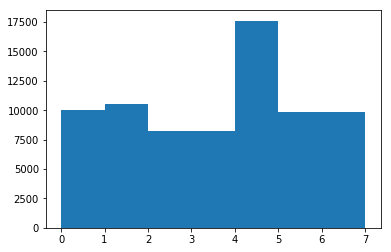

In [14]:
print('все классы после добавления нулевых в 20к датасете')
plt.hist(labels_20k,7,[0,7]);  
plt.show()

print('все классы после добавления нулевых в 10к датасете')
plt.hist(labels_10k,7,[0,7]);  
plt.show()

Препроцессиг стр 479

как варик - нормализация яркости?


In [15]:
# normalize all intensities to be between 0 and 1
#X = np.array(X).astype(np.float32) / 255
# subtract mean
#X = [x - np.mean(x) for x in X]


Проверка размеров изображений

Выделение фич:

In [19]:
from numpy.linalg import norm

#просто серый
def getGrayFeatures(X):
    return [cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in X]

#hsv
def getHSVFeatures(X):
    return [cv2.cvtColor(x, cv2.COLOR_BGR2HSV) for x in X]

#limited SURF
def getSURFFeatures(X):
    surf = cv2.SURF(400)
    surf.upright = True
    surf.extended = True
    kp_des = [surf.compute(x, kp) for x in X]
    num_surf_features = 36
    return [d[1][:num_surf_features, :] for d in kp_des]

#HOGs
def hog(img,step):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)
    bin_n = 16 # Number of bins
    bin = np.int32(bin_n*ang/(2*np.pi))

    bin_cells = []
    mag_cells = []

    cellx = celly = step
    
    for i in range(0,int(img.shape[0]/celly)):
        for j in range(0,int(img.shape[1]/cellx)):
            bin_cells.append(bin[i*celly : i*celly+celly, j*cellx : j*cellx+cellx])
            mag_cells.append(mag[i*celly : i*celly+celly, j*cellx : j*cellx+cellx])   

    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)

    # transform to Hellinger kernel
    eps = 1e-7
    hist /= hist.sum() + eps
    hist = np.sqrt(hist)
    hist /= norm(hist) + eps
    return hist

def getHOGFeatures(X,step):
    return [hog(x,step) for x in X]

Считаем фичи, плющим массивы

In [21]:
#hog8
X_20k_hog8 = getHOGFeatures(X_20k,8)
X_10k_hog8 = getHOGFeatures(X_10k,8)

#hog4
X_20k_hog4 = getHOGFeatures(X_20k,4)
X_10k_hog4 = getHOGFeatures(X_10k,4)

In [ ]:
#surf
#нада opencv_contrib!!!
#X_20k_surf = getSURFFeatures(X_20k)
#X_10k_surf = getSURFFeatures(X_10k)

In [93]:
#X_surf = getSURFFeatures(X_mod)
#X_hog = getHOGFeatures(X)

#плющим массивы
#X_hog = [x.flatten() for x in X_hog]

Случайное разделение
X_train, y_train, X_test, y_test

In [22]:
from sklearn.model_selection import train_test_split

In [24]:
X_train_20k8, X_test_20k8, y_train_20k8, y_test_20k8 = train_test_split(X_20k_hog8, labels_20k, test_size=0.25, random_state=42)

X_train_10k8, X_test_10k8, y_train_10k8, y_test_10k8 = train_test_split(X_10k_hog8, labels_10k, test_size=0.25, random_state=42)

X_train_20k4, X_test_20k4, y_train_20k4, y_test_20k4 = train_test_split(X_20k_hog4, labels_20k, test_size=0.25, random_state=42)

X_train_10k4, X_test_10k4, y_train_10k4, y_test_10k4 = train_test_split(X_10k_hog4, labels_10k, test_size=0.25, random_state=42)

print("Data prepared")

Data prepared


In [25]:
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
import itertools

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
#20k 0ых, hog8
#X_train_20k8, X_test_20k8, y_train_20k8, y_test_20k8

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
#param_grid = {'C': [1e3],'gamma': [0.0005], }
clf_20k8 = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf_20k8 = clf_20k8.fit(X_train_20k8, y_train_20k8)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf_20k8.best_estimator_)

Fitting the classifier to the training set
done in 15125.596s
Best estimator found by grid search:
SVC(C=10000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [28]:
accuracy_20k8 = clf_20k8.best_estimator_.score(X_test_20k8,y_test_20k8)
print(accuracy_20k8)

0.987599182781


accuracy
confusion matrix
precision
recall

Confusion matrix, without normalization
[[4912   12    1   10   18   21    5]
 [  12 2558    2    0    3    2    1]
 [  13    2 1999    1    2    1    3]
 [  12    2    8 1971    2    4    1]
 [  22    1    3    2 4396    7    6]
 [  22    2    4    5   10 2475    1]
 [  16    5    9    4    4    0 2475]]
Normalized confusion matrix
[[  9.87e-01   2.41e-03   2.01e-04   2.01e-03   3.62e-03   4.22e-03
    1.00e-03]
 [  4.65e-03   9.92e-01   7.76e-04   0.00e+00   1.16e-03   7.76e-04
    3.88e-04]
 [  6.43e-03   9.90e-04   9.89e-01   4.95e-04   9.90e-04   4.95e-04
    1.48e-03]
 [  6.00e-03   1.00e-03   4.00e-03   9.86e-01   1.00e-03   2.00e-03
    5.00e-04]
 [  4.96e-03   2.25e-04   6.76e-04   4.51e-04   9.91e-01   1.58e-03
    1.35e-03]
 [  8.73e-03   7.94e-04   1.59e-03   1.98e-03   3.97e-03   9.83e-01
    3.97e-04]
 [  6.37e-03   1.99e-03   3.58e-03   1.59e-03   1.59e-03   0.00e+00
    9.85e-01]]


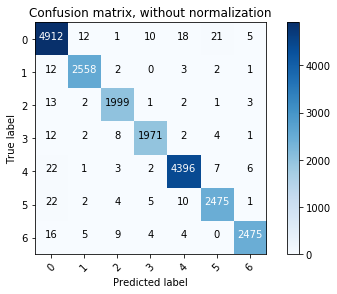

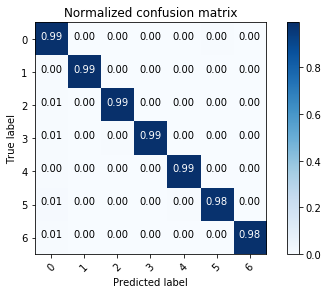

In [29]:
y_pred_20k8 = clf_20k8.best_estimator_.predict(X_test_20k8)
cnf_matrix = confusion_matrix(y_test_20k8,y_pred_20k8)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["0","1","2","3","4","5","6"],
                    title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["0","1","2","3","4","5","6"], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [30]:
#10k 0ых, hog8
#X_train_10k8, X_test_10k8, y_train_10k8, y_test_10k8

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
#param_grid = {'C': [1e3],'gamma': [0.0005], }
clf_10k8 = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf_10k8 = clf_10k8.fit(X_train_10k8, y_train_10k8)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf_10k8.best_estimator_)

Fitting the classifier to the training set
done in 10560.907s
Best estimator found by grid search:
SVC(C=5000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [31]:
accuracy_10k8 = clf_10k8.best_estimator_.score(X_test_10k8,y_test_10k8)
print(accuracy_10k8)

0.988839165364


Confusion matrix, without normalization
[[2497    8    0    5   11   13    8]
 [  11 2597    1    0    0    5    2]
 [   7    2 2044    4    4    3    4]
 [   7    2    4 1975    3    4    0]
 [  14    3    6    7 4421    5   10]
 [  17    1    2    5    7 2467    0]
 [  11    3    1    3    4    0 2339]]
Normalized confusion matrix
[[  9.82e-01   3.15e-03   0.00e+00   1.97e-03   4.33e-03   5.11e-03
    3.15e-03]
 [  4.20e-03   9.93e-01   3.82e-04   0.00e+00   0.00e+00   1.91e-03
    7.65e-04]
 [  3.38e-03   9.67e-04   9.88e-01   1.93e-03   1.93e-03   1.45e-03
    1.93e-03]
 [  3.51e-03   1.00e-03   2.01e-03   9.90e-01   1.50e-03   2.01e-03
    0.00e+00]
 [  3.13e-03   6.72e-04   1.34e-03   1.57e-03   9.90e-01   1.12e-03
    2.24e-03]
 [  6.80e-03   4.00e-04   8.00e-04   2.00e-03   2.80e-03   9.87e-01
    0.00e+00]
 [  4.66e-03   1.27e-03   4.24e-04   1.27e-03   1.69e-03   0.00e+00
    9.91e-01]]


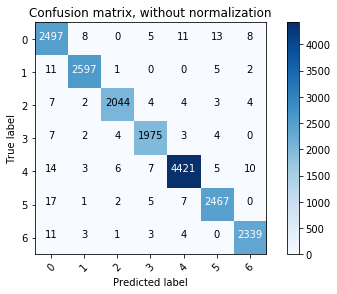

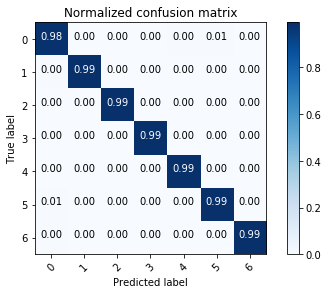

In [32]:
y_pred_10k8 = clf_10k8.best_estimator_.predict(X_test_10k8)
cnf_matrix = confusion_matrix(y_test_10k8,y_pred_10k8)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["0","1","2","3","4","5","6"],
                    title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["0","1","2","3","4","5","6"], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [33]:
#20k 0ых, hog4
#X_train_20k4, X_test_20k4, y_train_20k4, y_test_20k4

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
#param_grid = {'C': [1e3],'gamma': [0.0005], }
clf_20k4 = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf_20k4 = clf_20k4.fit(X_train_20k4, y_train_20k4)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf_20k4.best_estimator_)

Fitting the classifier to the training set
done in 25733.655s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [34]:
accuracy_20k4 = clf_20k4.best_estimator_.score(X_test_20k4,y_test_20k4)
print(accuracy_20k4)

0.991732788521


Confusion matrix, without normalization
[[4961    5    2    3    4    0    4]
 [   7 2563    0    2    2    2    2]
 [   6    4 2005    2    2    0    2]
 [   8    0    9 1975    6    1    1]
 [  13    0    3    1 4410    8    2]
 [  12    4    4    6   10 2482    1]
 [  13    6    8    2    7    0 2477]]
Normalized confusion matrix
[[  9.96e-01   1.00e-03   4.02e-04   6.03e-04   8.03e-04   0.00e+00
    8.03e-04]
 [  2.72e-03   9.94e-01   0.00e+00   7.76e-04   7.76e-04   7.76e-04
    7.76e-04]
 [  2.97e-03   1.98e-03   9.92e-01   9.90e-04   9.90e-04   0.00e+00
    9.90e-04]
 [  4.00e-03   0.00e+00   4.50e-03   9.88e-01   3.00e-03   5.00e-04
    5.00e-04]
 [  2.93e-03   0.00e+00   6.76e-04   2.25e-04   9.94e-01   1.80e-03
    4.51e-04]
 [  4.76e-03   1.59e-03   1.59e-03   2.38e-03   3.97e-03   9.85e-01
    3.97e-04]
 [  5.17e-03   2.39e-03   3.18e-03   7.96e-04   2.79e-03   0.00e+00
    9.86e-01]]


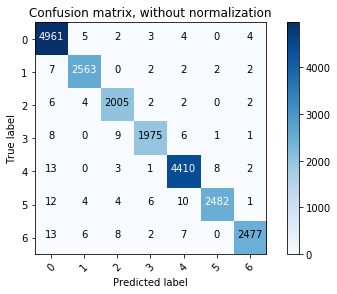

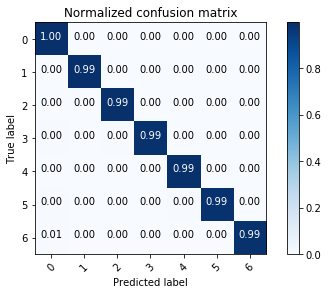

In [35]:
y_pred_20k4 = clf_20k4.best_estimator_.predict(X_test_20k4)
cnf_matrix = confusion_matrix(y_test_20k4,y_pred_20k4)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["0","1","2","3","4","5","6"],
                    title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["0","1","2","3","4","5","6"], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [36]:
#10k 0ых, hog4
#X_train_10k4, X_test_10k4, y_train_10k4, y_test_10k4 

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
#param_grid = {'C': [1e3],'gamma': [0.0005], }
clf_10k4 = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf_10k4 = clf_10k4.fit(X_train_10k4, y_train_10k4)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf_10k4.best_estimator_)

Fitting the classifier to the training set


KeyboardInterrupt: 

In [ ]:
accuracy_10k4 = clf_10k4.best_estimator_.score(X_test_10k4,y_test_10k4)
print(accuracy_10k4)

In [ ]:
y_pred_10k4 = clf_10k4.best_estimator_.predict(X_test_10k4)
cnf_matrix = confusion_matrix(y_test_10k4,y_pred_10k4)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["0","1","2","3","4","5","6"],
                    title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["0","1","2","3","4","5","6"], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

сохранение классификаторов

In [55]:
import pickle

In [38]:
pickle.dump(clf_20k8, open("clf_20k8.pkl", "wb"))
pickle.dump(clf_10k8, open("clf_10k8.pkl", "wb"))
pickle.dump(clf_20k4, open("clf_20k4.pkl", "wb"))

In [56]:
X_5k = X + X_zero[:5000]
labels_5k = labels + labels_zero[:5000]

X_5k_hog4 = getHOGFeatures(X_5k,4)

In [57]:
X_train_5k8, X_test_5k8, y_train_5k8, y_test_5k8 = train_test_split(X_5k_hog4, labels_5k, test_size=0.25, random_state=42)

In [58]:
print("Fitting the classifier to the training set")
t0 = time()
#param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
param_grid = {'C': [5e3],'gamma': [0.0005], }
clf_5k8 = GridSearchCV(SVC(kernel='rbf', class_weight='balanced',probability=True), param_grid)
clf_5k8 = clf_5k8.fit(X_train_5k8, y_train_5k8)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf_5k8.best_estimator_)

Fitting the classifier to the training set
done in 2363.752s
Best estimator found by grid search:
SVC(C=5000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [59]:
accuracy_5k8 = clf_5k8.best_estimator_.score(X_test_5k8,y_test_5k8)
print(accuracy_5k8)

0.972596404001


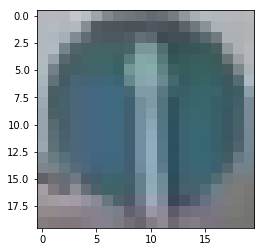

[4]
[[  3.61e-06   2.57e-06   3.72e-06   3.77e-06   9.97e-01   5.13e-06
    3.01e-03]]


In [63]:

imActFw = cv2.imread('D:\\ComputerVision\\_robocar\\RoadSignDetector\\_verification\\pic\\turnsigns\\actFw_rt.png')
imActFw_cut = cv2.resize(imActFw,(20, 20), interpolation = cv2.INTER_CUBIC)

plt.imshow(cv2.cvtColor(imActFw_cut,cv2.COLOR_BGR2RGB))
plt.show()

hog_test = hog(imActFw_cut,4)
arr = [hog_test]
print(clf_5k8.best_estimator_.predict(arr))

print(clf_5k8.best_estimator_.predict_proba(arr))
